In [ ]:

import os
from src.llm_annotate.core import *

book = "pride and prejudice"

traits = {
    "agreeableness": {
        "trait_explanation": "Agreeableness refers to traits that promote social harmony and cooperation.",
        "examples": [
            {"name": "John Doe",
             "action": "Volunteers at a local homeless shelter.", 
             "assessment": "Volunteering is a time-intensive and communal activity.",
             "rating": 3},
            {"name": "Jane Smith",
             "action": "Refuses to help a friend in need.", 
             "assessment": "In this particular scene, the character seemed rather self-centered.",
             "rating": -2}
        ]
    },
    "social dominance orientation": {
        "trait_explanation": "Social dominance orientation refers to the extent to which an individual prefers hierarchical relationships between social groups.",
        "examples": [
            {"name": "John Doe",
             "action": "Supports policies that favor the wealthy.",
             "assessment": "This action suggests that the character is rather unfazed by issues of social inequality.",
             "rating": 3},
            {"name": "Jane Smith",
             "action": "Marries someone from a lower social class.",
             "assessment": "This action indicates that Jane no longer cares as much about rising through social hierarchies.",
             "rating": -2}
        ]
    }
}


In [ ]:
#custom chunking
with open("data/pride and prejudice/novel.txt", 'r', encoding='utf-8') as f:
    noveltext = f.read()

chunk_text(noveltext, outputfile="data/pride and prejudice/chunks.json", custom_splitter="<SPLIT_HERE>")
annotate(chunkfile="data/pride and prejudice/chunks.json", outputfile="data/pride and prejudice/annotations.json", model=custom_openai, book_title=book, traits=traits)
disambiguate("data/pride and prejudice/annotations.json", "data/pride and prejudice/annotations_refined.json", "data/pride and prejudice/chunks.json", model=custom_openai, book_title=book, list_of_pseudonym_lists=[['Elizabeth', 'Lizzy', 'Elizabeth Bennet'], ['Mr. Darcy', 'Fitzwilliam Darcy', 'Darcy'], ['Jane Bennet', 'Jane']])

In [ ]:
#default chunking
with open("data/pride and prejudice/novel.txt", 'r', encoding='utf-8') as f:
    noveltext = f.read()

chunk_text(noveltext, outputfile="data/pride and prejudice/chunks_default.json")
annotate(chunkfile="data/pride and prejudice/chunks_default.json", outputfile="data/pride and prejudice/annotations_default.json", model=custom_openai, book_title=book, traits=traits)
disambiguate("data/pride and prejudice/annotations_default.json", "data/pride and prejudice/annotations_refined_default.json", "data/pride and prejudice/chunks_default.json", model=custom_openai, book_title=book, list_of_pseudonym_lists=[['Elizabeth', 'Lizzy', 'Elizabeth Bennet'], ['Mr. Darcy', 'Fitzwilliam Darcy', 'Darcy'], ['Jane Bennet', 'Jane']])

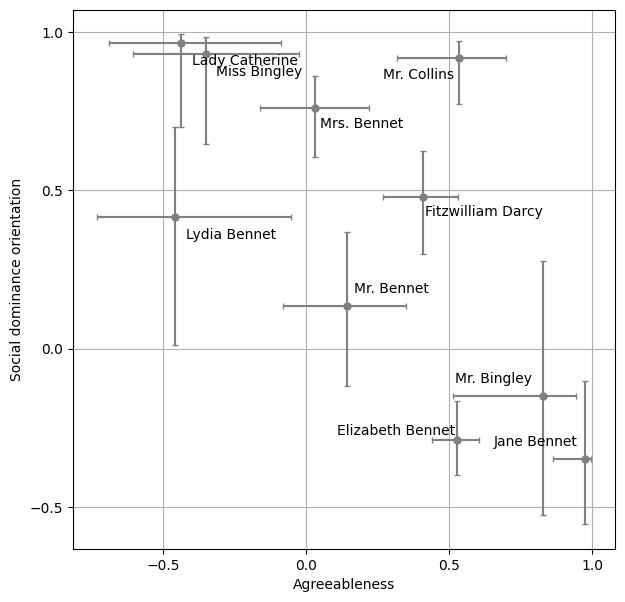

Pearson correlation coefficient: -0.6886431555734033, p-value: 0.027658267828934366
Degrees of freedom: 8


In [21]:
# compute_annotation_statistics("data/pride and prejudice/annotations_refined.json", 
#                               outputfile="data/pride and prejudice/statistics.json", plot=False)

import json
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

# Dynamically get trait names from traits1
trait_names = list(traits.keys())

# Combine statistics from all books
statistics = {}

with open("data/pride and prejudice/statistics_default.json", "r", encoding="utf-8") as f:
    book_stats = json.load(f)
    for char in book_stats:
        book_stats[char]["book"] = book
    statistics.update(book_stats)

# Compute total observations for each character (sum of all trait_n)
obs_counts = {
    char: sum(stats.get(f"{trait.capitalize()}_n", 0) for trait in trait_names)
    for char, stats in statistics.items()
}

# Take the 10 characters with the most observations
final_chars = [char for char, _ in sorted(obs_counts.items(), key=lambda kv: kv[1], reverse=True)[:10]]

# Extract trait scores and confidence intervals for plotting
trait_scores = {trait: [statistics[char][trait.capitalize()] for char in final_chars] for trait in trait_names}
trait_lowers = {trait: [statistics[char][f"{trait.capitalize()}_lower"] for char in final_chars] for trait in trait_names}
trait_uppers = {trait: [statistics[char][f"{trait.capitalize()}_upper"] for char in final_chars] for trait in trait_names}

plt.figure(figsize=(7,7))
for i, char in enumerate(final_chars):
    x = trait_scores[trait_names[0]][i]
    y = trait_scores[trait_names[1]][i]
    xerr = [
        abs(x - trait_lowers[trait_names[0]][i]),
        abs(trait_uppers[trait_names[0]][i] - x)
    ]
    yerr = [
        abs(y - trait_lowers[trait_names[1]][i]),
        abs(trait_uppers[trait_names[1]][i] - y)
    ]
    plt.errorbar(
        x, y,
        xerr=np.array(xerr).reshape(2,1),
        yerr=np.array(yerr).reshape(2,1),
        color='gray',
        markersize=5,
        marker='o',
        capsize=2,
        label=statistics[char]['book'] if statistics[char]['book'] not in plt.gca().get_legend_handles_labels()[1] else ""
    )
    # Offset text so it doesn't overlap the point and stays inside the grid
    xlim = plt.xlim()
    ylim = plt.ylim()
    x_offset = 0.02 * (xlim[1] - xlim[0])
    y_offset = 0.02 * (ylim[1] - ylim[0])
    ha = 'left' if x < (xlim[0] + xlim[1]) / 2 else 'right'
    va = 'bottom' if y < (ylim[0] + ylim[1]) / 2 else 'top'
    plt.text(
        x + (x_offset if ha == 'left' else -x_offset),
        y + (y_offset if va == 'bottom' else -y_offset),
        char, fontsize=10, ha=ha, va=va, color='black'
    )

plt.xlabel(trait_names[0].capitalize())
plt.ylabel(trait_names[1].capitalize())
plt.grid(True)

# Set half-point ticks on both axes
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))

plt.show()

#correlate sdo and agreeableness
import numpy as np
from scipy.stats import pearsonr
all_scores = {trait: [statistics[char][trait.capitalize()] for char in final_chars] for trait in trait_names}
sdo_scores = all_scores['social dominance orientation']
agreeableness_scores = all_scores['agreeableness']
correlation, p_value = pearsonr(sdo_scores, agreeableness_scores)
df = len(sdo_scores) - 2
print(f"Pearson correlation coefficient: {correlation}, p-value: {p_value}")
print(f"Degrees of freedom: {df}")

In [ ]:
#custom chunking
score_annotations(annotation_file="data/pride and prejudice/annotations.json", outputfile="data/pride and prejudice/evaluation.jsonl", chunkfile="data/pride and prejudice/chunks.json", num_annotations=100, labels=['Correct', 'Likely correct', 'Unclear', 'Likely incorrect', 'Incorrect'])

Scoring 100 out of 747 total annotations.
Found existing output file: data/pride and prejudice/evaluation.json
Resuming from annotation 22 of 100


In [ ]:
#default chunking
score_annotations(annotation_file="data/pride and prejudice/annotations_default.json", outputfile="data/pride and prejudice/evaluation_default.jsonl", chunkfile="data/pride and prejudice/chunks_default.json", num_annotations=100, labels=['Correct', 'Likely correct', 'Unclear', 'Likely incorrect', 'Incorrect'])

Scoring 100 out of 2454 total annotations.
Found existing output file: data/pride and prejudice/evaluation_default.json
Resuming from annotation 62 of 100


Custom chunking counts: [67, 21, 9, 3, 0]
Default chunking counts: [64, 25, 8, 3, 0]


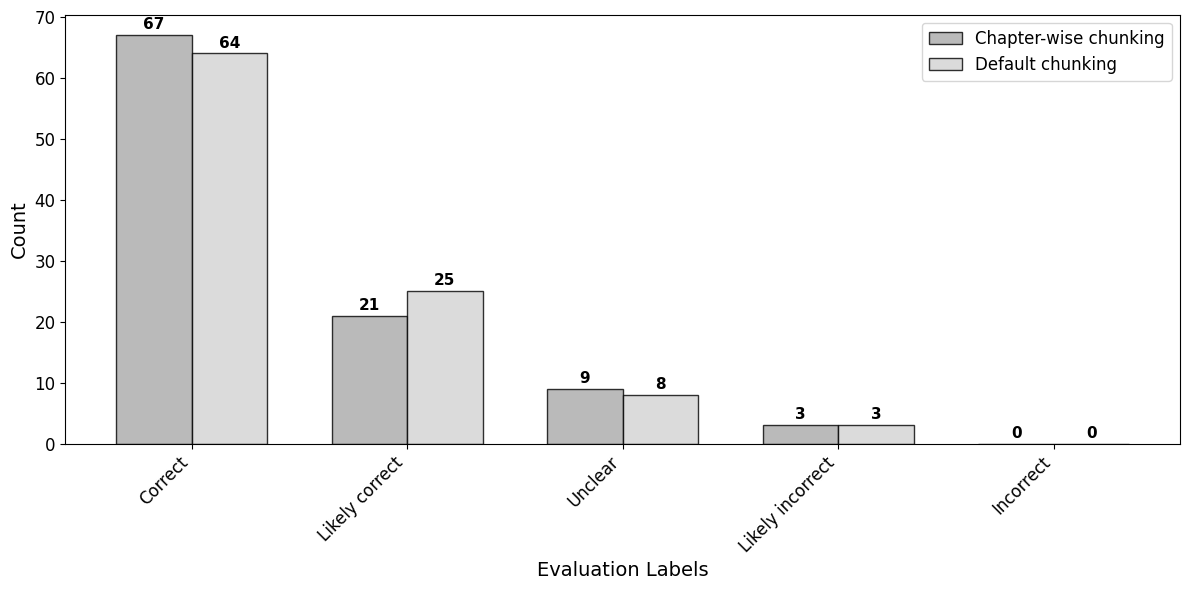


Accuracy comparison (Correct + Likely correct):
Chapter-wise chunking: 88/100 = 88.0%
Default chunking: 89/100 = 89.0%


In [7]:
#plot accuracy of default vs custom chunking
import json
import matplotlib.pyplot as plt
from collections import Counter

# Read JSONL files and collect all evaluations
custom_evaluations = []
with open("data/pride and prejudice/evaluation.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            custom_evaluations.append(json.loads(line.strip()))

default_evaluations = []
with open("data/pride and prejudice/evaluation_default.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            default_evaluations.append(json.loads(line.strip()))

# Count labels
labels = ['Correct', 'Likely correct', 'Unclear', 'Likely incorrect', 'Incorrect']
custom_label_counts = Counter([eval_item['human_label'] for eval_item in custom_evaluations])
default_label_counts = Counter([eval_item['human_label'] for eval_item in default_evaluations])

custom_counts = [custom_label_counts.get(label, 0) for label in labels]
default_counts = [default_label_counts.get(label, 0) for label in labels]

print("Custom chunking counts:", custom_counts)
print("Default chunking counts:", default_counts)

# Create a comparison plot
import numpy as np

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, custom_counts, width, label='Chapter-wise chunking', 
               color='darkgray', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, default_counts, width, label='Default chunking', 
               color='lightgray', edgecolor='black', alpha=0.8)

ax.set_xlabel('Evaluation Labels', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate accuracy percentages
total_custom = sum(custom_counts)
total_default = sum(default_counts)

# Consider "Correct" and "Likely correct" as positive
positive_custom = custom_counts[0] + custom_counts[1]  # Correct + Likely correct
positive_default = default_counts[0] + default_counts[1]  # Correct + Likely correct

custom_accuracy = (positive_custom / total_custom) * 100 if total_custom > 0 else 0
default_accuracy = (positive_default / total_default) * 100 if total_default > 0 else 0

print(f"\nAccuracy comparison (Correct + Likely correct):")
print(f"Chapter-wise chunking: {positive_custom}/{total_custom} = {custom_accuracy:.1f}%")
print(f"Default chunking: {positive_default}/{total_default} = {default_accuracy:.1f}%")